<a href="https://colab.research.google.com/github/JesseJames50/Analise-Dados-Financeiros/blob/main/previs%C3%A3o_pre%C3%A7o_a%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install pandas
!pip install scikit-learn

In [1]:
#importando as bibliotecas
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Definição do período dos dados e dos ativos
ativos = ['TRPL4.SA']
start = '2023-01-30'
end = '2024-05-08'

In [18]:
# Coleta de Dados
dados = yf.download(ativos, start=start, end=end)
dados = dados[['Close']]  # Usando duplos colchetes para manter como DataFrame
dados.head()

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2023-01-30,22.639999
2023-01-31,22.870001
2023-02-01,22.559999
2023-02-02,22.459999
2023-02-03,22.180000


In [19]:
#Verificando as colunas
print(dados.columns)

Index(['Close'], dtype='object')


In [20]:
# fazendo uma cópia explícita do Dataframe
df = dados.copy()  # Faça uma cópia explícita se não tiver certeza

# Adicionando lag features usando .loc para evitar SettingWithCopyWarning
df.loc[:, 'lag1'] = df['Close'].shift(1)
df.loc[:, 'lag2'] = df['Close'].shift(2)

# Removendo linhas com NaN de forma segura
df.dropna(inplace=True)

In [21]:
# Confirmando se as colunas foram adicionadas corretamente
print(df.head())
print("Colunas no DataFrame:", df.columns)

                Close       lag1       lag2
Date                                       
2023-02-01  22.559999  22.870001  22.639999
2023-02-02  22.459999  22.559999  22.870001
2023-02-03  22.180000  22.459999  22.559999
2023-02-06  22.160000  22.180000  22.459999
2023-02-07  21.980000  22.160000  22.180000
Colunas no DataFrame: Index(['Close', 'lag1', 'lag2'], dtype='object')


In [22]:
#Preparar e Escalar os Dados
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features = ['Close', 'lag1', 'lag2']  # Colunas para escalar

# Verifique se as colunas especificadas estão presentes
print("Verificando colunas selecionadas para escalonamento:", df[features].head())

df_scaled = scaler.fit_transform(df[features])

# Divisão em características (features) e alvo (target)
X = df_scaled[:, 1:]  # Todas as colunas exceto a primeira são características
y = df_scaled[:, 0]   # A primeira coluna é o alvo

print("Forma de X após escalonamento:", X.shape)


Verificando colunas selecionadas para escalonamento:                 Close       lag1       lag2
Date                                       
2023-02-01  22.559999  22.870001  22.639999
2023-02-02  22.459999  22.559999  22.870001
2023-02-03  22.180000  22.459999  22.559999
2023-02-06  22.160000  22.180000  22.459999
2023-02-07  21.980000  22.160000  22.180000
Forma de X após escalonamento: (313, 2)


In [23]:
# Dividir os Dados em Treino e Teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Forma de X_train:", X_train.shape)
print("Forma de X_test:", X_test.shape)


Forma de X_train: (250, 2)
Forma de X_test: (63, 2)


In [24]:
# Treinamento do Modelo
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train, y_train)


MLPRegressor(max_iter=500)

In [25]:
# Prever Usando o Modelo
# Últimos dados conhecidos (últimos 2 dias)
last_known_data = df_scaled[-2:, 1:]  # As últimas duas características (lag1 e lag2)

# Preparar uma lista para coletar as previsões
future_prices = []

# Prever para os próximos 15 dias
current_features = last_known_data
for _ in range(15):
    # Faz a previsão para o próximo dia
    next_price = mlp.predict(current_features)
    # Adiciona a previsão à lista
    future_prices.append(next_price[0])

    # Atualiza as características para a próxima previsão
    # Usando a última previsão como lag1 e a previsão anterior como lag2
    current_features = np.array([[current_features[0][1], next_price[0]]])

# Criando um novo scaler apenas para 'Close'
# e assumindo que 'df' ainda tem suas colunas originais e é onde você ajustou seu scaler originalmente
scaler_for_close = MinMaxScaler()
scaler_for_close.fit(df[['Close']])  # Usando duplo colchetes para manter a forma (n, 1)

# Agora use este scaler para desnormalizar suas previsões
future_prices_descaled = scaler_for_close.inverse_transform(np.array(future_prices).reshape(-1, 1))

print("Previsões dos próximos 15 dias:")
print(future_prices_descaled.ravel())


Previsões dos próximos 15 dias:
[25.71923035 25.54265764 25.51166856 25.4193022  25.38330562 25.3304026
 25.30095039 25.26773842 25.24388431 25.22064016 25.20123797 25.18313664
 25.16743806 25.15315957 25.14057124]


In [26]:
# Definindo o período para plotar o gráfico
# Supondo que o último dia em seus dados conhecidos seja 2024-05-07
start_date = pd.to_datetime('2024-05-08')
dates = pd.date_range(start=start_date, periods=15, freq='D')


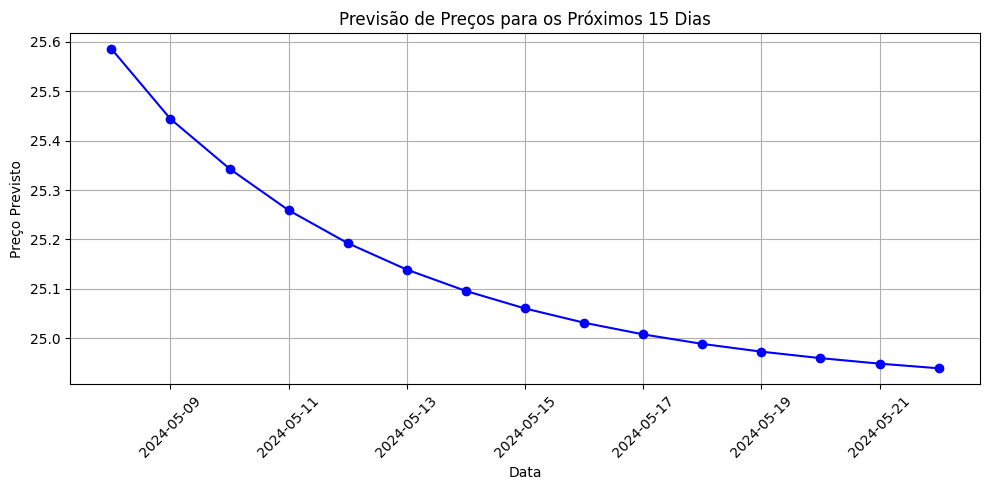

In [17]:
plt.figure(figsize=(10, 5))  # Define o tamanho da figura
plt.plot(dates, future_prices_descaled.ravel(), marker='o', linestyle='-', color='b')  # Linha com marcadores
plt.title('Previsão de Preços para os Próximos 15 Dias')  # Título do gráfico
plt.xlabel('Data')  # Rótulo do eixo X
plt.ylabel('Preço Previsto')  # Rótulo do eixo Y
plt.grid(True)  # Adiciona uma grade para melhor visualização
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo X para melhor visualização
plt.tight_layout()  # Ajusta subplots para que o gráfico fique dentro da figura
plt.show()  # Mostra o gráfico
